<a href="https://colab.research.google.com/github/Congliu0829/cencus_dnn_caching/blob/master/test_all_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_utils import *
from dataset import Dataset
from basicnet import Net
import matplotlib.pyplot as plt

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

params = {'benchmark': 'adult', 'maxlen': 0, 'batch_size': 500,
          'split': [0.7, 0.2, 0.1], 'seed': 2,
          'epochs': 100, 'lr': 0.001}
data = Dataset(params, 'train', device)

model = Net(data.nfeatures, [10,5])
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

/content/dataloader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[0]
/content/dataloader.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[y_feat][column] = classes[1]


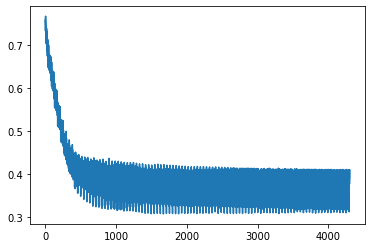

In [ ]:
y_loss=[]
for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        optimizer.zero_grad()
        ŷ = model(x)
        loss = loss_fn(ŷ, y)
        y_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
plt.plot(y_loss)

In [ ]:
from cache import Cache
cache = Cache(2) # we'll use only the hidden layers

for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        h2 = model.get_embedding(x, 1) 
        cache.store(h2, 1)

        h3 = model.get_embedding(x, 2) 
        cache.store(h3, 2)

In [ ]:
from autoencoder import AutoEncoder
ae1 = AutoEncoder(model._l_dim[1], 2)
ae2 = AutoEncoder(model._l_dim[2], 2)

ae_loss1 = nn.MSELoss()
ae_loss2 = nn.MSELoss()
opt1 = optim.Adam(ae1.parameters(), lr=0.001)
opt2 = optim.Adam(ae2.parameters(), lr=0.001)

y1_loss=[]
y2_loss=[]
h1 = []
h2 = []
oh1 = []
oh2 = []

for epoch in range(5):#params['epochs']):
    for x1 in cache.embeddings[1]:
        opt1.zero_grad()
        x̃1 = ae1(x1)
        oh1.append(x1)
        h1.append(x̃1)
        l1 = ae_loss1(x̃1, x1)
        l1.backward(retain_graph=True)
        opt1.step() 
        y1_loss.append(l1.item())
    
    for x2 in cache.embeddings[2]:
        opt2.zero_grad()
        x̃2 = ae2(x2)
        oh2.append(x2)
        h2.append(x̃2)
        l2 = ae_loss2(x̃2, x2)
        l2.backward(retain_graph=True)
        opt2.step()
        y2_loss.append(l2.item())

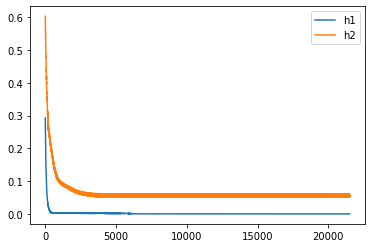

In [ ]:
plt.plot(y1_loss)
plt.plot(y2_loss)
plt.legend(['h1', 'h2'])

In [ ]:
'''This aims to split tensors so that batchsize will be equal to 1'''
from split import *
split_1 = []
split_1 = split(cache.embeddings[1], split_1)
split_2 = []
split_2 = split(cache.embeddings[2], split_2)


In [ ]:
'''This aims to store the first and second element of the output tensor, in order to construct bins'''
a1 = []
b1 = []
a2 = []
b2 = []
for x in split_1:
  x_out1 = ae1(x)
  a1.append(x_out1.detach().numpy()[0][0])
  b1.append(x_out1.detach().numpy()[0][1])

for x in split_2:
  x_out2 = ae2(x)
  a2.append(x_out2.detach().numpy()[0][0])
  b2.append(x_out2.detach().numpy()[0][1])



In [ ]:
from histogram import Histogram
histogram1 = Histogram('Histogram of first element of h1', a1, max(a1), min(a1))
histogram2 = Histogram('Histogram of second element of h1', b1, max(b1), min(b1))
histogram3 = Histogram('Histogram of first element of h2', a2, max(a2), min(a2))
histogram4 = Histogram('Histogram of second element of h2', b2, max(b2), min(b2))

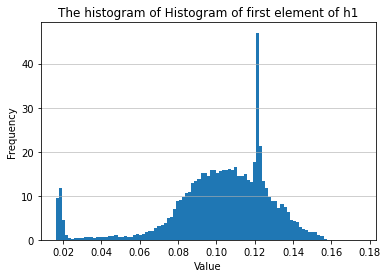

In [ ]:
histogram1.plot(histogram1.data, histogram1.dataname, histogram1.bins)

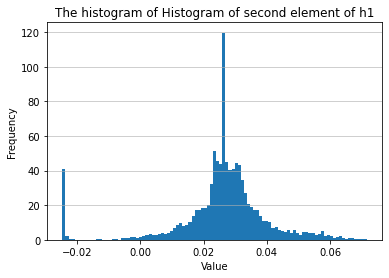

In [ ]:
histogram2.plot(histogram2.data, histogram2.dataname, histogram2.bins)

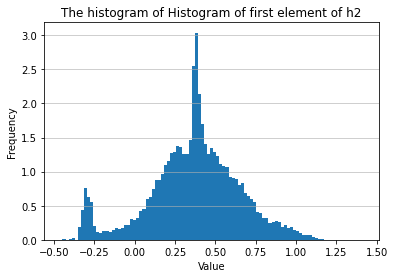

In [ ]:
histogram3.plot(histogram3.data, histogram3.dataname, histogram3.bins)

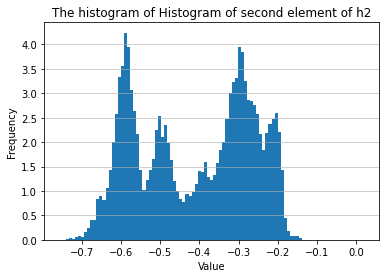

In [ ]:
histogram4.plot(histogram4.data, histogram4.dataname, histogram4.bins)